__Imports__

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm, trange
from termcolor import colored
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#nltk.download()

/opt/homebrew/Caskroom/miniforge/base/envs/py3_base/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


__Read in Data__

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


__Exploratory Data Analysis__

In [3]:
df.describe()

,score
count,36473.000000
mean,0.362062
std,0.258335
min,0.000000
25%,0.250000
50%,0.250000
75%,0.500000
max,1.000000


In [4]:
df.isnull().any()

id         False
anchor     False
target     False
context    False
score      False
dtype: bool

### Anchor Column Exploratory Analysis

In [5]:
print(f"Number of uniques values in ANCHOR column: {colored(df.anchor.nunique(), 'blue')}")

Number of uniques values in ANCHOR column: 733


__Amount of values with respect to the length of anchor__

In [6]:
df['anchor_len'] = df['anchor'].str.split().str.len()
df.anchor_len.value_counts()

2    24485
3     7556
1     3377
4      856
5      199
Name: anchor_len, dtype: int64

__Top 20 anchor values__

In [7]:
df.anchor.value_counts().head(20)

component composite coating         152
sheet supply roller                 150
source voltage                      140
perfluoroalkyl group                136
el display                          135
average pore size                   133
speed control means                 130
parallel orientation                127
displacement mechanism              124
cathode layer                       118
flow openings                       117
electromagnetic radiation source    115
overall weight                      114
central flow path                   111
elastic assembly                    109
dimensional location                109
hydrocarbyl substituted succinic    108
conductor particles                 108
oxidizing enzyme                    107
stabilizer members                  107
Name: anchor, dtype: int64

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

__Word Cloud__

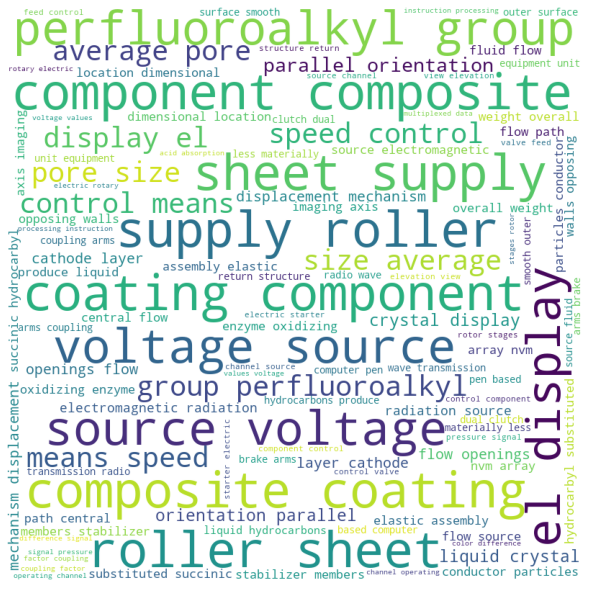

In [9]:
anchor_desc = df[df.anchor.notnull()].anchor.values
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      stopwords = stopwords,).generate(' '.join(anchor_desc)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

<AxesSubplot:>

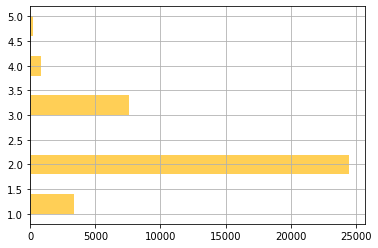

In [10]:
df.anchor_len.hist(orientation='horizontal', color='#FFCF56')

These are the unique amount of words in __anchor__ column max is 5

In [11]:
print("These are the possible amount of words in the anchor column: {}".format(np.unique(np.array(df['anchor'].apply(lambda x : len(x.split()))))))

These are the possible amount of words in the anchor column: [1 2 3 4 5]


__Check for numerical values in the Anchor column__

In [12]:
pattern = '[0-9]'
mask = df['anchor'].str.contains(pattern, na=False)
df['num_target'] = mask
df[mask]['anchor'].value_counts()

transistor m6               37
her2 targeted               32
vegfr2                      25
conh2                       22
dry coating composition1     2
Name: anchor, dtype: int64

### Target Column Exploratory Data Analysis

In [13]:
print(f"Number of uniques values in TARGET column: {colored(df.target.nunique(), 'green')}")

Number of uniques values in TARGET column: 29340


These are the unique amount of words in __target__ column max is 15

In [14]:
print("These are the possible amount of words in the target column: {}".format(np.unique(np.array(df['target'].apply(lambda x : len(x.split()))))))

These are the possible amount of words in the target column: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15]


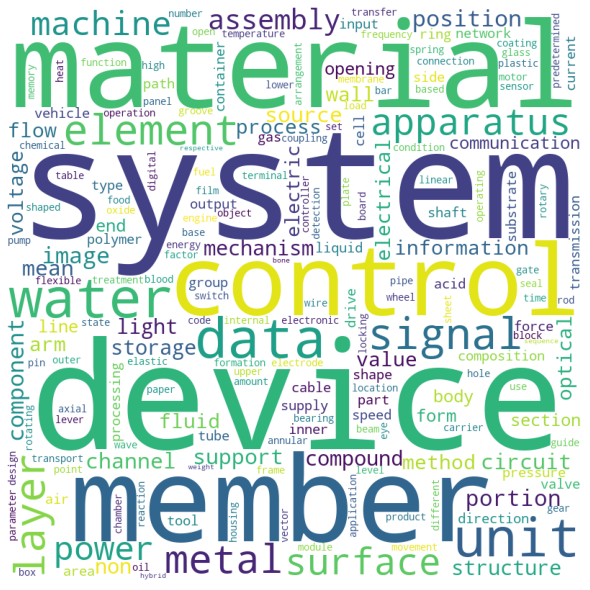

In [15]:
target_desc = df[df.target.notnull()].target.values
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      stopwords = stopwords,).generate(' '.join(target_desc)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [16]:
df['target_len'] = df['target'].str.split().str.len()
df.target_len.value_counts()

2     19099
3      8503
1      6872
4      1606
5       272
6        76
7        26
8         7
10        3
9         3
13        2
12        2
15        1
11        1
Name: target_len, dtype: int64

<AxesSubplot:>

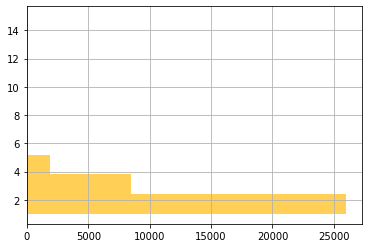

In [17]:
df.target_len.hist(orientation='horizontal', color='#FFCF56')

__Check for numerical values in Target__

In [18]:
pattern = '[0-9]'
mask = df['target'].str.contains(pattern, na=False)
df['num_target'] = mask
df[mask]['target'].value_counts()

1 bromopropane                     2
consist of ethane 12 dioic acid    2
tetrahydro 1h imidazo              2
methyl 3h imidazo                  2
eastman g 3003                     2
                                  ..
expandable 3 d scaffolding         1
display 3 dimensional image        1
sio2 fillers                       1
3d position                        1
h2o product                        1
Name: target, Length: 112, dtype: int64

__This is the amount of words in each row with respect to the column__
* Must be applied to anchor and target

In [19]:
np.unique(np.array(df['context']))

array(['A01', 'A21', 'A22', 'A23', 'A24', 'A41', 'A43', 'A44', 'A45',
       'A46', 'A47', 'A61', 'A62', 'A63', 'B01', 'B02', 'B03', 'B05',
       'B07', 'B08', 'B21', 'B22', 'B23', 'B24', 'B25', 'B27', 'B28',
       'B29', 'B31', 'B32', 'B41', 'B44', 'B60', 'B61', 'B62', 'B63',
       'B64', 'B65', 'B66', 'B67', 'B81', 'C01', 'C02', 'C03', 'C04',
       'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14',
       'C21', 'C22', 'C23', 'C25', 'D01', 'D03', 'D04', 'D05', 'D06',
       'D21', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E21', 'F01',
       'F02', 'F03', 'F04', 'F15', 'F16', 'F17', 'F21', 'F22', 'F23',
       'F24', 'F25', 'F26', 'F27', 'F28', 'F41', 'F42', 'G01', 'G02',
       'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11',
       'G16', 'G21', 'H01', 'H02', 'H03', 'H04', 'H05'], dtype=object)

In [20]:
df.context.value_counts().head(15)

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
C07    1069
G06    1063
B60     916
B01     891
G02     877
H03     798
B65     764
B41     650
C08     649
B23     648
Name: context, dtype: int64

In [21]:
print(np.unique(np.array(df['context'].apply(lambda x : len(x.split())))))

[1]


In [22]:
print(f"Number of uniques values in CONTEXT column: {colored(df.context.nunique(), 'yellow')}")

Number of uniques values in CONTEXT column: 106


__We need to seperate the context feature engineer the context__

In [23]:
df['section'] = df['context'].astype(str).str[0]
df['classes'] = df['context'].astype(str).str[1:]
df.head(10)

,id,anchor,target,context,score,anchor_len,num_target,target_len,section,classes
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,1,False,3,A,47
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,1,False,3,A,47
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,1,False,2,A,47
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,1,False,2,A,47
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,1,False,2,A,47
5,067203128142739c,abatement,greenhouse gases,A47,0.25,1,False,2,A,47
6,061d17f04be2d1cf,abatement,increased rate,A47,0.25,1,False,2,A,47
7,e1f44e48399a2027,abatement,measurement level,A47,0.25,1,False,2,A,47
8,0a425937a3e86d10,abatement,minimising sounds,A47,0.50,1,False,2,A,47
9,ef2d4c2e6bbb208d,abatement,mixing core materials,A47,0.25,1,False,3,A,47


In [24]:
print(f"Number of uniques SECTIONS: {colored(df.section.nunique(), 'yellow')}")
print(f"Number of uniques CLASS: {colored(df.classes.nunique(), 'yellow')}")

Number of uniques SECTIONS: 8
Number of uniques CLASS: 44


__We need to create a dictionary__

In [25]:
meanings = {"A" : "A - Human Necessities", 
      "B" : "B - Operations and Transport",
      "C" : "C - Chemistry and Metallurgy",
      "D" : "D - Textiles",
      "E" : "E - Fixed Constructions",
      "F" : "F- Mechanical Engineering",
      "G" : "G - Physics",
      "H" : "H - Electricity",
      "Y" : "Y - Emerging Cross-Sectional Technologies"}

<AxesSubplot:>

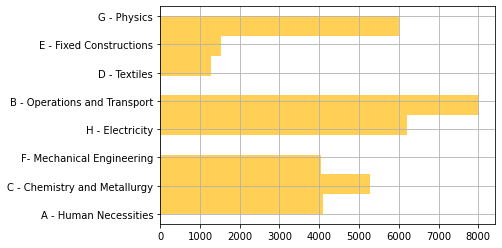

In [26]:
df.replace({"section": meanings}).section.hist(orientation='horizontal', color='#FFCF56')

In [27]:
df.classes.value_counts().head(15)

01    6851
04    3630
02    2310
03    2130
61    1771
06    1468
05    1325
07    1294
21    1269
16    1145
23    1126
41     960
60     916
08     891
09     872
Name: classes, dtype: int64

__Titles was gotten from doing more research on CPC Codes__

In [28]:
cpc_codes_df = pd.read_csv("data/cpc_codes_titles.csv", dtype=str)
cpc_codes_df.head(10)

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,01,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,01,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,01,B,1,00
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,01,B,1,02
5,A01B1/022,{Collapsible; extensible; combinations with ot...,A,01,B,1,022
6,A01B1/024,{Foot protectors attached to the blade},A,01,B,1,024
7,A01B1/026,{with auxiliary handles for facilitating lifting},A,01,B,1,026
8,A01B1/028,{with ground abutment shoes or earth anchors f...,A,01,B,1,028
9,A01B1/04,with teeth,A,01,B,1,04


__Let's join two datasets and add descriprion of context to our training DS__

In [29]:
df['context_desc'] = df['context'].map(cpc_codes_df.set_index('code')['title']).str.lower()

In [30]:
df.head()

,id,anchor,target,context,score,anchor_len,num_target,target_len,section,classes,context_desc
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,1,False,3,A,47,furniture; domestic articles or appliances; co...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,1,False,3,A,47,furniture; domestic articles or appliances; co...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,1,False,2,A,47,furniture; domestic articles or appliances; co...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,1,False,2,A,47,furniture; domestic articles or appliances; co...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,1,False,2,A,47,furniture; domestic articles or appliances; co...


In [31]:
df.drop("num_target",axis=1,inplace=True)

In [32]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,1,3,A,47,furniture; domestic articles or appliances; co...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,1,3,A,47,furniture; domestic articles or appliances; co...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,1,2,A,47,furniture; domestic articles or appliances; co...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,1,2,A,47,furniture; domestic articles or appliances; co...


__Tokenization__

In [33]:
df['target'] = df['target'].apply(lambda x : word_tokenize(x))
df['anchor'] = df['anchor'].apply(lambda x : word_tokenize(x))
df['context_desc'] = df['context_desc'].apply(lambda x : word_tokenize(x))

In [34]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc
0,37d61fd2272659b1,[abatement],"[abatement, of, pollution]",A47,0.50,1,3,A,47,"[furniture, ;, domestic, articles, or, applian..."
1,7b9652b17b68b7a4,[abatement],"[act, of, abating]",A47,0.75,1,3,A,47,"[furniture, ;, domestic, articles, or, applian..."
2,36d72442aefd8232,[abatement],"[active, catalyst]",A47,0.25,1,2,A,47,"[furniture, ;, domestic, articles, or, applian..."
3,5296b0c19e1ce60e,[abatement],"[eliminating, process]",A47,0.50,1,2,A,47,"[furniture, ;, domestic, articles, or, applian..."
4,54c1e3b9184cb5b6,[abatement],"[forest, region]",A47,0.00,1,2,A,47,"[furniture, ;, domestic, articles, or, applian..."


__Stopwords Removal__

In [35]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['target'] = df['target'].apply(lambda x : [w for w in x if not w in stop_words])
df['anchor'] = df['anchor'].apply(lambda x : [w for w in x if not w in stop_words])
df['context_desc'] = df['context_desc'].apply(lambda x : [w for w in x if not w in stop_words])

In [36]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc
0,37d61fd2272659b1,[abatement],"[abatement, pollution]",A47,0.50,1,3,A,47,"[furniture, ;, domestic, articles, appliances,..."
1,7b9652b17b68b7a4,[abatement],"[act, abating]",A47,0.75,1,3,A,47,"[furniture, ;, domestic, articles, appliances,..."
2,36d72442aefd8232,[abatement],"[active, catalyst]",A47,0.25,1,2,A,47,"[furniture, ;, domestic, articles, appliances,..."
3,5296b0c19e1ce60e,[abatement],"[eliminating, process]",A47,0.50,1,2,A,47,"[furniture, ;, domestic, articles, appliances,..."
4,54c1e3b9184cb5b6,[abatement],"[forest, region]",A47,0.00,1,2,A,47,"[furniture, ;, domestic, articles, appliances,..."


__Stemming__

In [37]:
from nltk.stem.snowball import SnowballStemmer
snowBallStemmer = SnowballStemmer("english")
df['target'] = df['target'].apply(lambda x : [snowBallStemmer.stem(word) for word in x])
df['anchor'] = df['anchor'].apply(lambda x: [snowBallStemmer.stem(word) for word in x])
df['context_desc'] = df['context_desc'].apply(lambda x: [snowBallStemmer.stem(word) for word in x])

In [38]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc
0,37d61fd2272659b1,[abat],"[abat, pollut]",A47,0.50,1,3,A,47,"[furnitur, ;, domest, articl, applianc, ;, cof..."
1,7b9652b17b68b7a4,[abat],"[act, abat]",A47,0.75,1,3,A,47,"[furnitur, ;, domest, articl, applianc, ;, cof..."
2,36d72442aefd8232,[abat],"[activ, catalyst]",A47,0.25,1,2,A,47,"[furnitur, ;, domest, articl, applianc, ;, cof..."
3,5296b0c19e1ce60e,[abat],"[elimin, process]",A47,0.50,1,2,A,47,"[furnitur, ;, domest, articl, applianc, ;, cof..."
4,54c1e3b9184cb5b6,[abat],"[forest, region]",A47,0.00,1,2,A,47,"[furnitur, ;, domest, articl, applianc, ;, cof..."


__Need to convert array to just strings__

In [39]:
df['anchor'] = df['anchor'].apply(lambda x : ' '.join(map(str,x)))
df['target'] = df['target'].apply(lambda x : ' '.join(map(str,x)))
df['context_desc'] = df['context_desc'].apply(lambda x : ' '.join(map(str,x)))

In [40]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc
0,37d61fd2272659b1,abat,abat pollut,A47,0.50,1,3,A,47,furnitur ; domest articl applianc ; coffe mill...
1,7b9652b17b68b7a4,abat,act abat,A47,0.75,1,3,A,47,furnitur ; domest articl applianc ; coffe mill...
2,36d72442aefd8232,abat,activ catalyst,A47,0.25,1,2,A,47,furnitur ; domest articl applianc ; coffe mill...
3,5296b0c19e1ce60e,abat,elimin process,A47,0.50,1,2,A,47,furnitur ; domest articl applianc ; coffe mill...
4,54c1e3b9184cb5b6,abat,forest region,A47,0.00,1,2,A,47,furnitur ; domest articl applianc ; coffe mill...


In [41]:
def create_feature(df, cpc_codes_df):    
    df['anchor_len'] = df['anchor'].apply(lambda x: len(x.split(' ')))
    df['target_len'] = df['target'].apply(lambda x: len(x.split(' ')))
    
    pattern = '[0-9]'
    mask = df['anchor'].str.contains(pattern, na=False)
    df['num_anchor'] = mask
    mask = df['target'].str.contains(pattern, na=False)
    df['num_target'] = mask
    
    df['context_desc'] = df['context'].map(cpc_codes_df.set_index('code')['title']).str.lower()
    
    fuzzy_anchor_target_scores = []
    fuzzy_anchor_context_scores = []
    fuzzy_taget_context_scores = []
    for index, row in df.iterrows():
        fuzzy_anchor_target_scores.append(fuzz.ratio(row['anchor'], row['target']))
        fuzzy_anchor_context_scores.append(fuzz.ratio(row['anchor'], row['context_desc']))
        fuzzy_taget_context_scores.append(fuzz.ratio(row['context_desc'], row['target']))
    df['fuzzy_at_score'] = fuzzy_anchor_target_scores
    df['fuzzy_ac_score'] = fuzzy_anchor_context_scores
    df['fuzzy_tc_score'] = fuzzy_taget_context_scores
    df['fuzzy_c_score'] = df['fuzzy_ac_score'] + df['fuzzy_tc_score']
    df['fuzzy_total'] = df['fuzzy_at_score'] + df['fuzzy_c_score']
    
    #df.drop(['context', 'fuzzy_ac_score', 'fuzzy_tc_score'], 1, inplace=True)
    
    return df

In [42]:
df = create_feature(df.copy(), cpc_codes_df)
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc,num_anchor,num_target,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,37d61fd2272659b1,abat,abat pollut,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,53,6,13,19,72
1,7b9652b17b68b7a4,abat,act abat,A47,0.75,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,67,6,8,14,81
2,36d72442aefd8232,abat,activ catalyst,A47,0.25,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,33,6,16,22,55
3,5296b0c19e1ce60e,abat,elimin process,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,0,6,14,20,20
4,54c1e3b9184cb5b6,abat,forest region,A47,0.00,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,12,6,20,26,38


In [43]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc,num_anchor,num_target,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,37d61fd2272659b1,abat,abat pollut,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,53,6,13,19,72
1,7b9652b17b68b7a4,abat,act abat,A47,0.75,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,67,6,8,14,81
2,36d72442aefd8232,abat,activ catalyst,A47,0.25,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,33,6,16,22,55
3,5296b0c19e1ce60e,abat,elimin process,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,0,6,14,20,20
4,54c1e3b9184cb5b6,abat,forest region,A47,0.00,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,12,6,20,26,38


Sets are important here because sets can only contain unique values

In [44]:
all_words = set()

This functions are not meant to return anything but to get the words into the set very quickly using a lambda function

In [45]:
def separator_all_words(arr):
    #for i in arr:
        all_words.add(arr)

In [46]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc,num_anchor,num_target,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,37d61fd2272659b1,abat,abat pollut,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,53,6,13,19,72
1,7b9652b17b68b7a4,abat,act abat,A47,0.75,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,67,6,8,14,81
2,36d72442aefd8232,abat,activ catalyst,A47,0.25,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,33,6,16,22,55
3,5296b0c19e1ce60e,abat,elimin process,A47,0.50,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,0,6,14,20,20
4,54c1e3b9184cb5b6,abat,forest region,A47,0.00,1,2,A,47,furniture; domestic articles or appliances; co...,False,False,12,6,20,26,38


In [47]:
df['anchor'].apply(lambda x: separator_all_words(x))
df['target'].apply(lambda x: separator_all_words(x))
df['context_desc'].apply(lambda x: separator_all_words(x))
df['section'].apply(lambda x: separator_all_words(x))
df['context'].apply(lambda x: separator_all_words(x))

0        None
1        None
2        None
3        None
4        None
         ... 
36468    None
36469    None
36470    None
36471    None
36472    None
Name: context, Length: 36473, dtype: object

__List comprehension of converting a set to a list__

In [48]:
entire = [i for i in all_words]

__Label Encoding__

In [49]:
#Only Used for test purposes of a sample of 1000
# main = df
# df = df.sample(1000)

In [50]:
labelencoder = LabelEncoder()
labelencoder.fit(entire)

LabelEncoder()

__For loop runs a lot faster than the lambda function idk why__

In [56]:
for i in tqdm(np.unique(df['anchor'])):
    df['anchor'].replace(i,labelencoder.transform([i])[0],inplace=True)

  0%|          | 0/733 [00:00<?, ?it/s]

In [57]:
for i in tqdm(np.unique(df['target'])):
    df['target'].replace(i,labelencoder.transform([i])[0],inplace=True)

  0%|          | 0/26589 [00:00<?, ?it/s]

In [58]:
for i in tqdm(np.unique(df['context'])):
    df['context'].replace(i,labelencoder.transform([i])[0],inplace=True)

  0%|          | 0/106 [00:00<?, ?it/s]

In [59]:
for i in tqdm(np.unique(df['section'])):
    df['section'].replace(i,labelencoder.transform([i])[0],inplace=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [60]:
for i in tqdm(np.unique(df['context_desc'])):
    df['context_desc'].replace(i,labelencoder.transform([i])[0],inplace=True)

  0%|          | 0/106 [00:00<?, ?it/s]

In [61]:
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc,num_anchor,num_target,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,37d61fd2272659b1,150,152,47,0.50,1,2,36,47,10209,False,False,53,6,13,19,72
1,7b9652b17b68b7a4,150,363,47,0.75,1,2,36,47,10209,False,False,67,6,8,14,81
2,36d72442aefd8232,150,382,47,0.25,1,2,36,47,10209,False,False,33,6,16,22,55
3,5296b0c19e1ce60e,150,8154,47,0.50,1,2,36,47,10209,False,False,0,6,14,20,20
4,54c1e3b9184cb5b6,150,9840,47,0.00,1,2,36,47,10209,False,False,12,6,20,26,38


### Model Evaluation

__Spliting (70/30)__
* Here we test/evaluate our models

In [62]:
x = df[['anchor','target','context',
        'anchor_len','target_len',
        'section','classes','context_desc',
        'fuzzy_at_score',
        'fuzzy_ac_score',
        'fuzzy_tc_score',
        'fuzzy_c_score',
        'fuzzy_total']].values
y = df['score'].values

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
test_size=0.10, 
random_state=42)

__Random Forest Regressor__

In [64]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(x,y)

RandomForestRegressor()

In [65]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mape = r2_score(y_test,y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(mse,rmse,mae,mape))

Mean Square Error: 0.0064706258796670005 
Root Mean Squared Error: 0.08044020064412445 
Mean Absolute Error: 0.059786632107612786 
R-Squared: 0.9039268348120812 


In [66]:
features = ['anchor','target','context','anchor_len','target_len','section','classes','context_desc','fuzzy_at_score','fuzzy_ac_score','fuzzy_tc_score','fuzzy_c_score','fuzzy_total']
feature_importance_nums = clf.feature_importances_*100
feature_importance_df = pd.DataFrame(feature_importance_nums).transpose()
feature_importance_df.columns = features
feature_importance_df.head()

,anchor,target,context,anchor_len,target_len,section,classes,context_desc,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,8.992179,14.189518,4.741911,1.636015,2.727276,0.962177,3.895607,4.327895,33.228311,5.422535,6.95252,6.000883,6.923173


__Cat Boosting Regression__

In [67]:
from catboost import CatBoostRegressor
cat_base = CatBoostRegressor(
    eval_metric='MAE'
)
cbf = cat_base.fit(x_train, y_train, silent=True)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
y_pred = cbf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mape = r2_score(y_test,y_pred)
rmse = mean_squared_error(y_test, y_pred,squared=False)
mae = mean_absolute_error(y_test,y_pred)
print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(mse,rmse,mae,mape))

Mean Square Error: 0.04462467518088042 
Root Mean Squared Error: 0.21124553292526785 
Mean Absolute Error: 0.16314837158085665 
R-Squared: 0.33743135983461003 


In [68]:
features = ['anchor','target','context','anchor_len','target_len','section','classes','context_desc','fuzzy_at_score','fuzzy_ac_score','fuzzy_tc_score','fuzzy_c_score','fuzzy_total']
feature_importance_nums = cbf.feature_importances_
feature_importance_df = pd.DataFrame(feature_importance_nums).transpose()
feature_importance_df.columns = features
feature_importance_df.head()

,anchor,target,context,anchor_len,target_len,section,classes,context_desc,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total
0,8.46404,11.756755,6.640583,2.937221,9.27247,1.866259,4.301432,4.631177,32.039869,4.272008,4.112016,4.264179,5.441991
